# Text Summarization by Fine Tuning Flan T5

In [45]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Dec  13 22:28:37 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   59C    P0             28W /   70W |   10574MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+----

In [ ]:
%pip install transformers datasets evaluate accelerate pipeline bitsandbytes
%pip install torch torchdata
%pip install peft
%pip install loralib
%pip install bert_score
%pip install rouge_score
%pip install huggingface_hub

In [3]:
import pandas as pd
import numpy as np
import json
import random
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    AutoModelForCausalLM,
    GenerationConfig,
    TrainingArguments,
    Trainer,
    pipeline,
    BitsAndBytesConfig,
    DataCollatorForSeq2Seq
)
import torch
import evaluate
from peft import (
    LoraConfig,
    get_peft_model,
    TaskType,
    PeftModel,
    PeftConfig,
)
from huggingface_hub import login

In [ ]:
login()

In [5]:
DIR_TRAIN = f"/content/drive/MyDrive/Colab Notebooks/fine-tuning-llm/summarize/peft/train/"
DIR_MODEL = f"/content/drive/MyDrive/Colab Notebooks/fine-tuning-llm/summarize/peft/models/"
DIR_EVAL = f"/content/drive/MyDrive/Colab Notebooks/fine-tuning-llm/summarize/"

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda')

### Fine Tuning Dataset: JamesLin0219/cyberSummarization
+ [ JamesLin0219/cyberSummarization](https://huggingface.co/datasets/JamesLin0219/cyberSummarization)

In [ ]:
# summarization dataset
data_cyber = load_dataset("JamesLin0219/cyberSummarization")
data_cyber

In [7]:
from datasets import DatasetDict

data_cyber = data_cyber.rename_columns({'text': 'document', '__index_level_0__': 'id'})

train_test_split = data_cyber['train'].train_test_split(test_size=0.3, seed=42)  # 70% train, 30% remaining
val_test_split = train_test_split['test'].train_test_split(test_size=0.5, seed=42)  # 15% validation, 15% test

# Create final DatasetDict
final_dataset = DatasetDict({
    'train': train_test_split['train'],
    'validation': val_test_split['train'],
    'test': val_test_split['test']
})

final_dataset


DatasetDict({
    train: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 28576
    })
    validation: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 6124
    })
    test: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 6124
    })
})

### Base Model: FLAN-T5 base
+ Steps:
 + Download the pre-trained model
 + Create a tokenizer
 + Define the base model (for fine-tuning)
 + Define the original model (for evaluation)
 + Move the models to the DEVICE (cpu, cuda)


In [ ]:
# FLANT5 Base Model
base_model_name = 'google/flan-t5-base'
tokenizer = AutoTokenizer.from_pretrained(base_model_name)

# base model for training
base_model = AutoModelForSeq2SeqLM.from_pretrained(base_model_name, torch_dtype=torch.bfloat16, device_map='auto')

# original model for evaluation
original_model = AutoModelForSeq2SeqLM.from_pretrained(base_model_name, torch_dtype=torch.bfloat16, device_map='auto')

### Prompt Engineering & Generation


In [9]:
def get_prompt(doc):
    """Format prompts for text summarization using FLAN-T5 models"""

    # T5 models require the 'summarize' keyword generate text summaries
    prompt = "Summarize the following document:\n\n"
    prompt += f"{doc}"
    prompt += "\n\n Summary:"
    return prompt

In [10]:
def get_response(prompt, model, tokenizer):
  """ Generate a text summary from the prompt """

  # tokenize the prompt
  # truncation and padding is required to ensure each document
  # is the same length
  MAX_TARGET_LENGTH = 64

  encoded_input = tokenizer(
      prompt,
      return_tensors="pt",
      add_special_tokens=False,
      padding='max_length',
      truncation=True
      )
  # move the inputs to the same DEVICE
  model_inputs = encoded_input.to(DEVICE)

  # generate the response
  generated_ids = model.generate(
      **model_inputs,
      max_new_tokens=MAX_TARGET_LENGTH,
      )

  # decode the response back to text
  decoded_output = tokenizer.batch_decode(generated_ids,skip_special_tokens=True)[0]

  return decoded_output

In [11]:
def print_example(summary,document ):
  """Print the original document, the human summary and
  the generated summary
   """
  # print the summaries
  print(f"Document:{summary['index']}")
  print("="*100)
  print(document)
  print("\nHuman Summary",'-'*88)
  print(summary['human'],'\n')
  print("GenAI Summary",'-'*88)
  print(summary['genai'])
  print("="*100,'\n')


In [37]:
def generate_responses(data, model, indexes, verbose=True):
    """Generate summaries for each example in the dataset"""

    # accumulator
    summaries=[]

    # for each example in the indexes
    for idx in indexes:
        # extract the document text and human summary
        document = data['test'][idx]['document']
        human_summary = data['test'][idx]['summary']

        # prepare the prompt
        prompt = get_prompt(document)

        # get the response
        genai_summary = get_response(prompt, model, tokenizer)

        # consolidate the example inputs, human summary and generated summary
        summary = {'index':idx,'human':human_summary,'genai':genai_summary}

        # accumulate summaries
        summaries.append(summary)

        # optional print dialogue & summary
        if verbose:
          print_example(summary,document)

    return summaries

In [39]:
# sample generations from the base model
summaries = generate_responses(
    final_dataset,
    base_model,
    [10,12],
    False
    )
df = pd.DataFrame(summaries)
df

,index,human,genai
0,10,this problem may be limited when Windows 95/98...,CVE-1999-1594 Status: Candidate Phase: Assigne...
1,12,BUGTRAQ:20020819 Re: @(#) Mordred Labs advisor...,"Armstrong, Green MODIFY(1) Cox NOOP(1) Cole Vo..."


### Preprocessing
+ The following preprocessing steps were required for instruction fine-tuning for text summarization tasks
	+ Tokenize the inputs and human-generated summaries
	+ Standardize the document lengths using truncation and padding
	+ Format the instruction prompt for T5 models to include the encoded document text and human-generated summaries
+ Apply all transformations to the train, test, and validation datasets

In [14]:
PREFIX = 'Summarize: '
MAX_INPUT_LENGTH = 1024
MAX_TARGET_LENGTH = 64

In [15]:
def preprocess_for_summarization(examples):
  """Prepare the dataset for instrucion fine-tuning """

  # document inputs
  docs = [PREFIX + doc for doc in examples['document']]

  # tokenize the documents
  model_inputs = tokenizer(
      docs,
      max_length=MAX_INPUT_LENGTH,
      truncation=True
      )

  # tokenize human-generated summaries
  labels = examples['summary']
  label_ids = tokenizer(
      text_target=examples['summary'],
      max_length=MAX_TARGET_LENGTH,
      padding='max_length',
      truncation=True
  )

  model_inputs['labels'] = label_ids['input_ids']

  return model_inputs

In [16]:
# tokenize all examples in each dataset, remove unnecessary features
tokenized_datasets = final_dataset.map(preprocess_for_summarization,batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(['document','summary','id'])
tokenized_datasets

Map:   0%|          | 0/28576 [00:00<?, ? examples/s]

Map:   0%|          | 0/6124 [00:00<?, ? examples/s]

Map:   0%|          | 0/6124 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 28576
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 6124
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 6124
    })
})

In [17]:
# LoRA configuation
lora_config = LoraConfig(
    r = 64, # dimension of adaptors, rank
    lora_alpha=128, # alpha scaling
    target_modules = ["q", "k", "v", "o"], # add LoRA adaptors to these layers in the base model
    lora_dropout=0.10, # regularization
    bias="none",
    task_type=TaskType.SEQ_2_SEQ_LM # text summarization
)

# create the PEFT model
peft_model = get_peft_model(base_model, lora_config)
peft_model.print_trainable_parameters()

trainable params: 14,155,776 || all params: 261,733,632 || trainable%: 5.4085


### Training

In [18]:
# Data Collator: This function dynamically sets the padding during training
# ensures prompts of are equal length
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=base_model)

# Training Config
config_training = TrainingArguments(
    output_dir=DIR_TRAIN,
    auto_find_batch_size=True,
    learning_rate=1e-4,
    logging_steps=1,
    max_steps=100
)

# Trainer
trainer = Trainer(
    model=peft_model,
    args=config_training,
    data_collator = data_collator,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation']
)

# train
trainer.train()

# save adaptor weights
trainer.save_model(DIR_MODEL)
# peft_model.push_to_hub(hub_name)

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ashrafamit9227 to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Step,Training Loss
1,6.750000
2,11.500000
3,6.593800
4,2.609400
5,6.156200
6,11.562500
7,11.312500
8,2.546900
9,5.062500
10,11.312500


### Merge Base Model & Adapters
+ The trained LoRA adaptors must be merged with the original base model
+ The resulting model consists of the base model plus the trained adaptors



In [19]:
# merge base model + peft adaptors
tuned_model = PeftModel.from_pretrained(
    base_model,
    DIR_MODEL, # LoRA adapters
    torch_dthype=torch.bfloat16,
    trust_remote_code=True,
    is_trainable=False
  )
tuned_model.print_trainable_parameters()
# tuned_model = tuned_model.merge_and_unload()

trainable params: 0 || all params: 261,733,632 || trainable%: 0.0000


### Evaluate Model Performance and Qualitative Comparision


In [35]:
def generate_both_model_responses(data, base_model, tuned_model, indexes, verbose=True):
    """Generate summaries for each example in the dataset"""

    # accumulator
    summaries=[]

    # for each example in the indexes
    for idx in indexes:
        # extract the document text and human summary
        document = data['test'][idx]['document']
        human_summary = data['test'][idx]['summary']

        # prepare the prompt
        prompt = get_prompt(document)

        # get the response
        base_ai_summary = get_response(prompt, base_model, tokenizer)

        tuned_ai_summary = get_response(prompt, tuned_model, tokenizer)

        # consolidate the example inputs, human summary and generated summary
        summary = {'document':document,'human':human_summary,'base model':base_ai_summary,'tuned model':tuned_ai_summary}

        # accumulate summaries
        summaries.append(summary)

        # optional print dialogue & summary
        if verbose:
          print_example(summary,document)

    return summaries

In [43]:
# sample generations from the base model
summaries = generate_both_model_responses(
    final_dataset,
    original_model,
    tuned_model,
    [10,11,12,13,14],
    False
    )
df = pd.DataFrame(summaries)
df

,document,human,base model,tuned model
0,NOTE: this problem may be limited when\nWindow...,this problem may be limited when Windows 95/98...,This problem occurs when a Windows 95/98 clien...,CVE-1999-1594 Status: Candidate Phase: Assigne...
1,Christey> Should revoked cert's be included in...,CERT-VN:VU#626919 Reference: http://www.kb.cer...,CVE-2000-0890 status: Entry Reference: BID:232...,CVE-2000-0890 Status: Entry Reference: BID:232...
2,"Armstrong, Green\n MODIFY(1) Cox\n NOOP(1)...",BUGTRAQ:20020819 Re: @(#) Mordred Labs advisor...,,"Armstrong, Green MODIFY(1) Cox NOOP(1) Cole Vo..."
3,Reference: URL:http://archives.neohapsis.com/a...,vsybase.c in vpopmail 5.4.2 and earlier has un...,vpopmail = 5.4.2 (sybase vulnerability) has un...,vpopmail = 5.4.2 (sybase vulnerability) (fwd)]...
4,My concern is in cases like \n this we used ...,"the vulnerability is a ""type"" of problem in th...",CVE is a type of problem in the same way as bu...,"CVE is a ""type"" of problem in the same way tha..."


### Quantitative Comparision
+ The hugging face library provides several metrics to evaluate summaries.  
	+ Rouge Score
	+ BERT Score




In [31]:
def get_model_evaluations(summaries):
  """
  Calculate Rouge & BERT scores for each example in the summaries dict
  Calculate an average overall score across all metrics
  """
  # extract the summaries
  idx =   [s['index'] for s in summaries]
  genai = [s['genai'] for s in summaries]
  human = [s['human'] for s in summaries]

  # calculate the rouge scores
  rouge = evaluate.load('rouge')
  r = rouge.compute(
    predictions = genai,
    references = human,
    use_aggregator=False,
    use_stemmer=True,
    rouge_types =  ['rouge1','rouge2','rougeL']
   )

  # calculate the BERT score
  bert = evaluate.load("bertscore")
  b = bert.compute(
      predictions = genai,
      references = human,
      lang='en'
  )['f1']

  # merge dicts and convert to a dataframe
  r.update({'bert':b})
  df = pd.DataFrame(r)

  # calculate the mean score
  df['overall_score'] = df.mean(axis = 1)

  # add the index from the test data
  df['idx'] = idx
  df = df.set_index('idx')

  return df

In [32]:
def compare_evaluations(base,tuned,metric_to_compare='overall_score',verbose=False):
  """Compare the overall_score between the base and tuned model for each test summary """

  # combine the base and tuned models by example id
  df = base.join(tuned, lsuffix='_base',rsuffix='_tuned')

  # calculate comparison by metric (tuned - base)
  df['diff'] = df.apply(lambda x: x[f"{metric_to_compare}_tuned"] - x[f"{metric_to_compare}_base"], axis=1)

  # add performance flag: add an indicator for each example that determines whether
  # the base or tuned model performed better
  df['best_model'] = df['diff'].apply(lambda x : 'tuned' if x >=0.0 else 'base')

  # print a summary
  if verbose:
    # get median values
    base_median = df[f"{metric_to_compare}_base"].median()
    tuned_median = df[f"{metric_to_compare}_tuned"].median()

    # get proportions
    df_counts = df['best_model'].value_counts(normalize=True).to_frame().T
    base_proportion = df_counts['base'].item()
    tuned_proportion = df_counts['tuned'].item()

    print(f"Model Comparision: {metric_to_compare}")
    print("="*100)
    print(f" Median Base Model = {base_median:,.2f} | Median Tuned Model = {tuned_median:,.2f}")
    print(f" Base model performed better for {base_proportion*100:,.2f}% of cases.")
    print(f" Tuned model performed better for {tuned_proportion*100:,.2f}% of cases.")
    print("="*100)

  return df

In [33]:
def plot_evaluation_metrics(scores_base, scores_tuned):
  """Create BoxPlots for each evaluation metric to compare the base & tuned models """

  # add model names
  scores_base['model'] = 'base'
  scores_tuned['model'] = 'tuned'

  # combine as a dataframe, convert to long format for plotting
  df = pd.concat([scores_base,scores_tuned])
  df_long = pd.melt(df, id_vars=['model'],var_name='metric',value_name='score')

  # plot
  plt.figure(figsize=(10,6))
  plot = sns.boxplot(x="metric", y="score",hue="model",data=df_long)
  plot.set(title = "Evaluation Metrics: Base model vs Fine Tuned Model")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model Comparision: overall_score
 Median Base Model = 0.28 | Median Tuned Model = 0.40
 Base model performed better for 29.00% of cases.
 Tuned model performed better for 71.00% of cases.


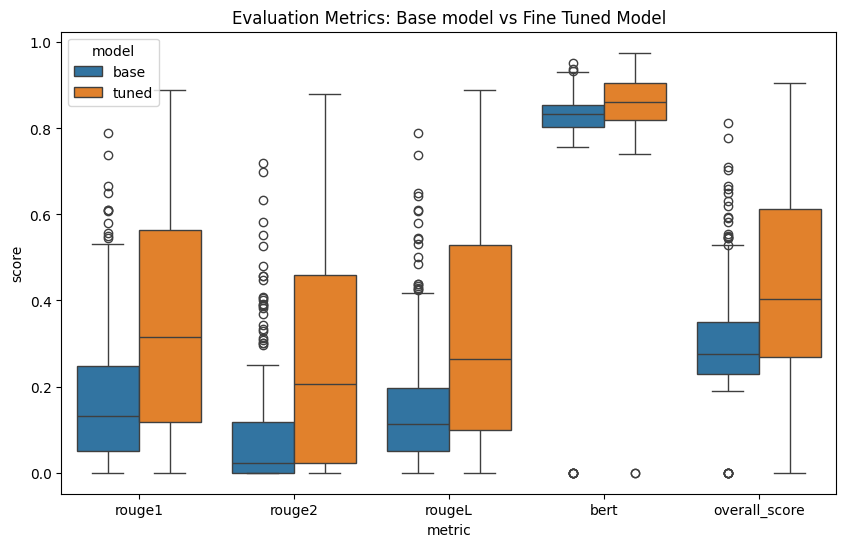

In [41]:
# generate summaries for sample test data
num_samples = final_dataset['test'].num_rows-1
num_to_test = 200
test_indexes = random.sample(range(num_samples),num_to_test)

# get responses from each model
summaries_base_model = generate_responses(final_dataset, original_model, test_indexes,False)
summaries_tuned_model = generate_responses(final_dataset, tuned_model, test_indexes,False)

# Evaluate the performace vs the human labels
# base model:
scores_base = get_model_evaluations(summaries_base_model)

# tuned model
scores_tuned = get_model_evaluations(summaries_tuned_model)

# compare models
scores = compare_evaluations(scores_base, scores_tuned,'overall_score',True)

# Plot Results
plot_evaluation_metrics(scores_base, scores_tuned)

### This means that,
+ On average, the fine-tuned model performs better than the base model as fine-tuned model had a higher median overall score of 0.40.
+ For 71% of test samples, the fine-tuned model produced summaries that were closer to human-written ones based on ROUGE and BERTScore.

In [42]:
!pip freeze > requirements.txt